# Semantic Similarity - Experiment 03
Employing the models trained in the previous notebooks to evaluate semantic similarity in the SICK dataset.

## Introduction

### Libraries

In [112]:
## Data analysis packages:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [8]:
## Visualization packages:
import plotly.express as px 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../source")  # Add the directory 'source' to sys.path

In [7]:
from sca_utils import TextClassifier

### Definitions

In [6]:
## Forcing Pandas to display any number of elements
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None)

### Importing SCA_utils methods:

In [11]:
## Instantiating the SCA Text Classifier:
classifier = TextClassifier(model_multiclass_path='../models/model_02_E.h5',
                            encoder_multiclass_path='../models/encoder_oneHot_E.pickle',
                            model_regression_path='../models/model_01_D2.h5')

In [10]:
## Testing classifier show method:
classifier.textClassifier_regression('trial')

1/1 [==============================] - 0s 186ms/step
--- trial:
38.19 of objectivity
56.73 of subjectivity


In [12]:
## Testing classifier return method:
classifier.textClassifier_getSCA_regression('trial')

1/1 [==============================] - 0s 88ms/step


(0.38186026, 0.5673055)

In [13]:
## Testing classifier return method:
classifier.textClassifier_getSCA_multiclass('trial')

1/1 [==============================] - 0s 101ms/step


'Latent'

## Importing SICK database
SICK (Sentences Involving Compositional Knowledge) data set, from University of Trento and available at http://clic.cimec.unitn.it/composes/sick/, "consists of 10,000 English sentence pairs, built starting from two existing paraphrase sets: the [8K ImageFlickr data set](http://nlp.cs.illinois.edu/HockenmaierGroup/data.html) and the [SEMEVAL-2012 Semantic Textual Similarity Video Descriptions data set](http://www.cs.york.ac.uk/semeval-2012/task6/index.php?id=data). Each sentence pair is annotated for relatedness in meaning and for the entailment relation between the two elements."

Fields description:
- pair_ID: sentence pair ID

- sentence_A: sentence A

- sentence_B: sentence B

- entailment_label: textual entailment gold label (NEUTRAL, ENTAILMENT, or CONTRADICTION)

- relatedness_score: semantic relatedness gold score (on a 1-5 continuous scale)

- entailment_AB: entailment for the A-B order (A_neutral_B, A_entails_B, or A_contradicts_B)

- entailment_BA: entailment for the B-A order (B_neutral_A, B_entails_A, or B_contradicts_A)

- sentence_A_original: original sentence from which sentence A is derived

- sentence_B_original: original sentence from which sentence B is derived

- sentence_A_dataset: dataset from which the original sentence A was extracted (FLICKR vs. SEMEVAL)

- sentence_B_dataset: dataset from which the original sentence B was extracted (FLICKR vs. SEMEVAL)

- SemEval_set: set including the sentence pair in SemEval 2014 Task 1 (TRIAL, TRAIN, or TEST)


In [14]:
## Reading the dataset file:
data_sick = pd.read_table('../data/dataset_SICK/SICK/SICK.txt')
## Gathering general information from the dataset (it is already prepared for analysis)
data_sick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pair_ID              9840 non-null   int64  
 1   sentence_A           9840 non-null   object 
 2   sentence_B           9840 non-null   object 
 3   entailment_label     9840 non-null   object 
 4   relatedness_score    9840 non-null   float64
 5   entailment_AB        9840 non-null   object 
 6   entailment_BA        9840 non-null   object 
 7   sentence_A_original  9840 non-null   object 
 8   sentence_B_original  9840 non-null   object 
 9   sentence_A_dataset   9840 non-null   object 
 10  sentence_B_dataset   9840 non-null   object 
 11  SemEval_set          9840 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 922.6+ KB


In [15]:
## Grouping by entailment label:
data_sick.groupby(['entailment_label'])['pair_ID'].agg('count').reset_index()

entailment_label  pair_ID
0    CONTRADICTION     1424
1       ENTAILMENT     2821
2          NEUTRAL     5595

----
#### Sampling N samples labeled as "contradiction" for exploratory analysis:
*A random state is set to allow reproducibility.*

In [22]:
## Defining the number of samples:
N_sick = 5
## Choosing arbitrarily a random state:
random_state = 98

In [23]:
## Sampling the SICK data labeled as "contradiction":
sample_sick = data_sick[data_sick['entailment_label'] == 'CONTRADICTION'].sample(n=N_sick, 
                                                                                 random_state=random_state)
sample_sick.head(2)

pair_ID                                                                              sentence_A                                                                               sentence_B entailment_label  relatedness_score    entailment_AB    entailment_BA                                             sentence_A_original                                             sentence_B_original sentence_A_dataset sentence_B_dataset SemEval_set  normalized_score
591       592  A woman is taking off a cloak, which is very large, and revealing an extravagant dress  A woman is putting on a cloak, which is very large, and concealing an extravagant dress    CONTRADICTION                3.5  A_contradicts_B  B_contradicts_A  A woman taking off a large cloak revealing a extravagant dress  A woman taking off a large cloak revealing a extravagant dress             FLICKR             FLICKR       TRIAL             0.625
9483     9643                                      A brown and white dog is running through the river                                   A brown and white dog is not running through the river    CONTRADICTION                3.6  A_contradicts_B  B_contradicts_A              a brown and white dog is running through the river              a brown and white dog is running through the river             FLICKR             FLICKR       TRAIN             0.650

What is the "relatedness score" variance?  
> From 1 to 5.

In [20]:
data_sick.relatedness_score.describe()

count    9840.000000
mean        3.525636
std         1.017050
min         1.000000
25%         3.000000
50%         3.600000
75%         4.300000
max         5.000000
Name: relatedness_score, dtype: float64

### Min-Max normalization of relatedness score:

$x_{\text{normalized}} = \frac{x - \min(x)}{\max(x) - \min(x)}$


In [21]:
## Normalizing the "Relatedness score", which is originally from 1 to 5 stars, to a value between 0 and 1:
data_sick['normalized_score'] = (data_sick['relatedness_score'] - data_sick['relatedness_score'].min()) / (data_sick['relatedness_score'].max() - data_sick['relatedness_score'].min())

In [24]:
data_sick.head(2)

pair_ID                                                                                  sentence_A                                                                         sentence_B entailment_label  relatedness_score    entailment_AB entailment_BA                                              sentence_A_original                                              sentence_B_original sentence_A_dataset sentence_B_dataset SemEval_set  normalized_score
0        1           A group of kids is playing in a yard and an old man is standing in the background       A group of boys in a yard is playing and a man is standing in the background          NEUTRAL                4.5      A_neutral_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN             0.875
1        2  A group of children is playing in the house and there is no man standing in the background  A group of kids is playing in a yard and an old man is standing in the background          NEUTRAL                3.2  A_contradicts_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN             0.550

<AxesSubplot: xlabel='relatedness_score', ylabel='normalized_score'>

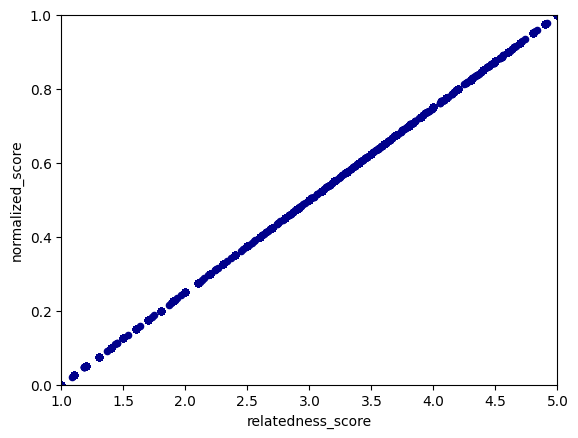

In [25]:
## Plotting "Relatedness score" versus "Normalized score". It is expected to see a line:
data_sick.plot.scatter(x='relatedness_score', y='normalized_score', c='DarkBlue', ylim=[0,1], xlim=[1,5])

----
### Picking a (not so) random phrase:

In [26]:
picked = data_sick.loc[1737]
picked

pair_ID                                             1758
sentence_A             There is no woman playing a flute
sentence_B                  One woman is playing a flute
entailment_label                           CONTRADICTION
relatedness_score                                    3.4
entailment_AB                            A_contradicts_B
entailment_BA                            B_contradicts_A
sentence_A_original        A woman is playing the flute.
sentence_B_original        A woman is playing the flute.
sentence_A_dataset                               SEMEVAL
sentence_B_dataset                               SEMEVAL
SemEval_set                                         TEST
normalized_score                                     0.6
Name: 1737, dtype: object

In [27]:
phrase_A = picked['sentence_A']
phrase_B = picked['sentence_B']
phrase_entailment = picked['entailment_label']

----
## Enriching SICK database

In [29]:
## Reading a sample of the SICK dataset:
data_sick.head(2)

pair_ID                                                                                  sentence_A                                                                         sentence_B entailment_label  relatedness_score    entailment_AB entailment_BA                                              sentence_A_original                                              sentence_B_original sentence_A_dataset sentence_B_dataset SemEval_set  normalized_score
0        1           A group of kids is playing in a yard and an old man is standing in the background       A group of boys in a yard is playing and a man is standing in the background          NEUTRAL                4.5      A_neutral_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN             0.875
1        2  A group of children is playing in the house and there is no man standing in the background  A group of kids is playing in a yard and an old man is standing in the background          NEUTRAL                3.2  A_contradicts_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN             0.550

### Calculating similarity between the two phrases of each sample:

In [30]:
## Calculating standard similary (using en_core_web_lg) and USE similarity (en_use_lg)
data_sick['Similarity_STD'] = data_sick.apply(lambda row: classifier.nlp_core(row['sentence_A']).similarity(classifier.nlp_core(row['sentence_B'])), axis=1)
data_sick['Similarity_USE'] = data_sick.apply(lambda row: classifier.nlp_use(row['sentence_A']).similarity(classifier.nlp_use(row['sentence_B'])), axis=1)

<AxesSubplot: xlabel='normalized_score', ylabel='Similarity_STD'>

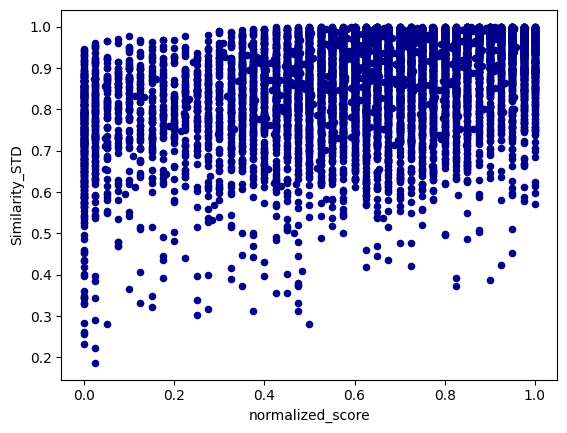

In [31]:
data_sick.plot.scatter(x='normalized_score', y='Similarity_STD', c='DarkBlue')

### Infering objectivity and subjectivity for each sentence:

In [32]:
## Infering objectivity and subjectivity values for sentence B:
data_sick['A_SCA'] = data_sick.apply(lambda row: classifier.textClassifier_getSCA_multiclass(row['sentence_A']), axis=1)
data_sick['B_SCA'] = data_sick.apply(lambda row: classifier.textClassifier_getSCA_multiclass(row['sentence_B']), axis=1)

## Infering objectivity and subjectivity values for sentence A:
data_sick[['A_obj', 'A_subj']] = data_sick.apply(lambda row: classifier.textClassifier_getSCA_regression(row['sentence_A']), axis=1, result_type='expand')

## Infering objectivity and subjectivity values for sentence B:
data_sick[['B_obj', 'B_subj']] = data_sick.apply(lambda row: classifier.textClassifier_getSCA_regression(row['sentence_B']), axis=1, result_type='expand')

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


### Adjusting columns order:

In [33]:
data_sick = data_sick[['pair_ID', 'sentence_A', 'sentence_B', 'entailment_label', 'normalized_score', 'Similarity_STD', 'Similarity_USE', 'A_obj', 'A_subj', 'B_obj','B_subj', 'A_SCA', 'B_SCA','relatedness_score', 'entailment_AB', 'entailment_BA', 'sentence_A_original', 'sentence_B_original', 'sentence_A_dataset', 'sentence_B_dataset', 'SemEval_set']]

In [34]:
data_sick.head(2)

pair_ID                                                                                  sentence_A                                                                         sentence_B entailment_label  normalized_score  Similarity_STD  Similarity_USE     A_obj    A_subj     B_obj    B_subj     A_SCA       B_SCA  relatedness_score    entailment_AB entailment_BA                                              sentence_A_original                                              sentence_B_original sentence_A_dataset sentence_B_dataset SemEval_set
0        1           A group of kids is playing in a yard and an old man is standing in the background       A group of boys in a yard is playing and a man is standing in the background          NEUTRAL             0.875        0.971317        0.870191  0.792531  0.370976  0.826164  0.335474  Manifest  Perceptual                4.5      A_neutral_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN
1        2  A group of children is playing in the house and there is no man standing in the background  A group of kids is playing in a yard and an old man is standing in the background          NEUTRAL             0.550        0.932352        0.547721  0.906428  0.285062  0.792531  0.370976  Manifest    Manifest                3.2  A_contradicts_B   B_neutral_A  A group of children playing in a yard, a man in the background.  A group of children playing in a yard, a man in the background.             FLICKR             FLICKR       TRAIN

### Exporting enriched SICK dataset

In [36]:
## Exporting data
# data_sick.to_parquet('../data/enriched_SICK_data.parquet')

In [11]:
## Importing data
data_sick = pd.read_parquet('../data/enriched_SICK_data.parquet')

---
## Dataframe analysis:

In [37]:
df_analysis = data_sick[['pair_ID','normalized_score','Similarity_STD','Similarity_USE','A_obj','A_subj','B_obj','B_subj','A_SCA','B_SCA']].copy()
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pair_ID           9840 non-null   int64  
 1   normalized_score  9840 non-null   float64
 2   Similarity_STD    9840 non-null   float64
 3   Similarity_USE    9840 non-null   float64
 4   A_obj             9840 non-null   float32
 5   A_subj            9840 non-null   float32
 6   B_obj             9840 non-null   float32
 7   B_subj            9840 non-null   float32
 8   A_SCA             9840 non-null   object 
 9   B_SCA             9840 non-null   object 
dtypes: float32(4), float64(3), int64(1), object(2)
memory usage: 615.1+ KB


In [43]:
df_analysis.head(2)

pair_ID  normalized_score  Similarity_STD  Similarity_USE     A_obj    A_subj     B_obj    B_subj     A_SCA       B_SCA  error_STD  error_USE  delta_Obj  delta_Subj
0        1             0.875        0.971317        0.870191  0.792531  0.370976  0.826164  0.335474  Manifest  Perceptual   0.096317   0.004809   0.033633    0.035501
1        2             0.550        0.932352        0.547721  0.906428  0.285062  0.792531  0.370976  Manifest    Manifest   0.382352   0.002279   0.113896    0.085914

### Evaluating similarity error

In [38]:
df_analysis['error_STD'] = np.abs(df_analysis['normalized_score']-df_analysis['Similarity_STD'])
df_analysis['error_USE'] = np.abs(df_analysis['normalized_score']-df_analysis['Similarity_USE'])

In [78]:
# Scatter plot para normalized_score vs Similarity_STD
fig_std = px.scatter(df_analysis, x='normalized_score', y='Similarity_STD', color='error_STD',
                     hover_data=['error_STD'], title='Normalized Score vs Similarity_STD',
                     color_continuous_scale='Viridis')

fig_std.show()

In [79]:

# Scatter plot para normalized_score vs Similarity_USE
fig_use = px.scatter(df_analysis, x='normalized_score', y='Similarity_USE', color='error_USE',
                     hover_data=['error_USE'], title='Normalized Score vs Similarity_USE',
                     color_continuous_scale='Viridis')

fig_use.show()


### Additional features

In [39]:
df_analysis['delta_Obj'] = np.abs(df_analysis['A_obj'] - df_analysis['B_obj'])
df_analysis['delta_Subj'] = np.abs(df_analysis['A_subj'] - df_analysis['B_subj'])

In [40]:
# df_analysis['avg_Obj'] = (df_analysis['A_obj'] + df_analysis['B_obj']) / 2.0
# df_analysis['avg_Subj'] = (df_analysis['A_subj'] + df_analysis['B_subj']) / 2.0

In [41]:
# df_analysis['max_Obj'] = df_analysis[['A_obj', 'B_obj']].max(axis=1)
# df_analysis['max_Subj'] = df_analysis[['A_subj', 'B_obj']].max(axis=1)

In [42]:
# df_analysis['min_Obj'] = df_analysis[['A_obj', 'B_obj']].min(axis=1)
# df_analysis['min_Subj'] = df_analysis[['A_subj', 'B_obj']].min(axis=1)

### Analysis 01: Are SCA labels related to the error rate?

In [58]:
## Auxiliar function to highlight values of interest
def highlight_high_values(val, upper_th=0.6, lower_th=0.4):
    ''' Highlights values higher than upper_th or lower than lower_th. Must be applied as a map in a Pandas.DataFrame style.
    '''
    # color = 'background-color: yellow' if ((val > th) or (val < -th)) else ''
    if (val > upper_th):
        color = 'background-color: red' 
    elif (val < lower_th):
        color = 'background-color: blue'
    else:
        color = ''
    return color

In [50]:
# Agrupando por 'A_SCA' e 'B_SCA' e calculando a média das colunas de interesse
analysis_01_grouped = df_analysis.groupby(['A_SCA', 'B_SCA']).agg({
    'error_STD': 'mean',
    'normalized_score': 'mean',
    'Similarity_STD': 'mean',
    'delta_Obj': 'mean',
    'delta_Subj': 'mean',
}).reset_index()

In [51]:
analysis_01_sorted = analysis_01_grouped.sort_values('error_STD', ascending=False)

#### Visual inspection: coloring by mean and std dev.
This strategy, though, may not apply since columns do not follow a normal distribution.

In [64]:
## Visual inspection using mean and standard deviation. 
analysis_01_highlighted_A = analysis_01_sorted.style.applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = analysis_01_sorted['error_STD'].mean() + analysis_01_sorted['error_STD'].std(),
                              lower_th = analysis_01_sorted['error_STD'].mean() - analysis_01_sorted['error_STD'].std()), 
                              subset=['error_STD']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = analysis_01_sorted['normalized_score'].mean() + analysis_01_sorted['normalized_score'].std(),
                              lower_th = analysis_01_sorted['normalized_score'].mean() - analysis_01_sorted['normalized_score'].std()), 
                              subset=['normalized_score']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = analysis_01_sorted['Similarity_STD'].mean() + analysis_01_sorted['Similarity_STD'].std(),
                              lower_th = analysis_01_sorted['Similarity_STD'].mean() - analysis_01_sorted['Similarity_STD'].std()), 
                              subset=['Similarity_STD']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = analysis_01_sorted['delta_Obj'].mean() + analysis_01_sorted['delta_Obj'].std(),
                              lower_th = analysis_01_sorted['delta_Obj'].mean() - analysis_01_sorted['delta_Obj'].std()), 
                              subset=['delta_Obj']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = analysis_01_sorted['delta_Subj'].mean() + analysis_01_sorted['delta_Subj'].std(),
                              lower_th = analysis_01_sorted['delta_Subj'].mean() - analysis_01_sorted['delta_Subj'].std()), 
                              subset=['delta_Subj']
)

In [66]:
analysis_01_highlighted_A

#### Visual inspection: coloring by defined thresholds.

In [69]:
## Visual inspection using mean and standard deviation. 
analysis_01_highlighted_B = analysis_01_sorted.style.applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = 0.3,
                              lower_th = 0.21), 
                              subset=['error_STD']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = 0.7,
                              lower_th = 0.6), 
                              subset=['normalized_score']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = 0.7,
                              lower_th = 0.6), 
                              subset=['Similarity_STD']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = 0.15,
                              lower_th = 0.10), 
                              subset=['delta_Obj']
).applymap(
    lambda x: highlight_high_values(x, 
                              upper_th = 0.15,
                              lower_th = 0.10), 
                              subset=['delta_Subj']
)

In [70]:
analysis_01_highlighted_B

### Analysis 02: evaluating a statistical relationship from the variables:
To check if there is a significant relationship between A_SCA, B_SCA, delta_Obj, delta_Subj with error_STD, we will train a multivariate linear regressor.

In [76]:
analysis_02 = analysis_01_sorted.copy()

In [77]:
# Supondo que df_analysis seja o seu DataFrame
# Codificar as variáveis categóricas
analysis_02 = pd.get_dummies(analysis_02, columns=['A_SCA', 'B_SCA'])

# Modelo de regressão linear múltipla incluindo interações, se desejado
X = analysis_02[['delta_Obj', 'delta_Subj'] + list(analysis_02.columns[analysis_02.columns.str.startswith('A_SCA_')]) +
                 list(analysis_02.columns[analysis_02.columns.str.startswith('B_SCA_')])]
y = analysis_02['error_STD']

# Adicionando constante ao modelo
X = sm.add_constant(X)

# Ajustando o modelo
model = sm.OLS(y, X).fit()

# Imprimindo o sumário do modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              error_STD   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     8.222
Date:                Tue, 13 Feb 2024   Prob (F-statistic):            0.00587
Time:                        20:27:02   Log-Likelihood:                 39.977
No. Observations:                  16   AIC:                            -61.95
Df Residuals:                       7   BIC:                            -55.00
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0904      0.016  

c:\Users\tiago\OneDrive - UNIVALI\PhD\atividades de pesquisa\semantic_similarity\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Analysis 03: reducing the number of variables by grouping SCA results
For the purpose of this study, it seems to be irrelevant the pair "manifest-latent" or "latent-manifest". Considering this, we will simplify how these data is presented grouping and aggregating them by means:

In [100]:
analysis_03 = analysis_01_sorted.copy()
analysis_03

A_SCA       B_SCA  error_STD  normalized_score  Similarity_STD  delta_Obj  delta_Subj
9     Manifest      Latent   0.384953          0.460303        0.833844   0.160983    0.187113
12  Perceptual  Contextual   0.371159          0.516071        0.887230   0.181462    0.080537
13  Perceptual      Latent   0.349466          0.533908        0.873375   0.178577    0.100616
6       Latent    Manifest   0.340848          0.523667        0.840012   0.163346    0.163928
14  Perceptual    Manifest   0.320876          0.543179        0.853130   0.056119    0.148418
11    Manifest  Perceptual   0.309785          0.558708        0.848757   0.050877    0.147896
8     Manifest  Contextual   0.270469          0.610127        0.867162   0.144316    0.064421
3   Contextual  Perceptual   0.253672          0.581369        0.830866   0.169390    0.194301
10    Manifest    Manifest   0.244538          0.656499        0.877018   0.039695    0.064407
15  Perceptual  Perceptual   0.227100          0.678191        0.877065   0.046313    0.077131
7       Latent  Perceptual   0.225987          0.680128        0.884240   0.152483    0.093327
1   Contextual      Latent   0.225921          0.729896        0.934469   0.076636    0.152314
2   Contextual    Manifest   0.205565          0.685354        0.864511   0.164877    0.065869
0   Contextual  Contextual   0.204428          0.776445        0.948173   0.070615    0.047662
4       Latent  Contextual   0.202585          0.693333        0.821898   0.078642    0.087234
5       Latent      Latent   0.184961          0.769428        0.933588   0.088105    0.059057

In [101]:
# Sorting the dataframe to explicit the variables relationships:
## Creating the columns "SCA_Combination"
analysis_03['SCA_Combination'] = analysis_03.apply(lambda x: '-'.join(sorted([x['A_SCA'], x['B_SCA']])), axis=1)

# Sorting by 'SCA_Combination':
analysis_03 = analysis_03.sort_values(['SCA_Combination', 'A_SCA', 'B_SCA'])

In [103]:
## Visualizing the values. Observe they are closer in the same SCA_Combination:
analysis_03

A_SCA       B_SCA  error_STD  normalized_score  Similarity_STD  delta_Obj  delta_Subj        SCA_Combination
0   Contextual  Contextual   0.204428          0.776445        0.948173   0.070615    0.047662  Contextual-Contextual
1   Contextual      Latent   0.225921          0.729896        0.934469   0.076636    0.152314      Contextual-Latent
4       Latent  Contextual   0.202585          0.693333        0.821898   0.078642    0.087234      Contextual-Latent
2   Contextual    Manifest   0.205565          0.685354        0.864511   0.164877    0.065869    Contextual-Manifest
8     Manifest  Contextual   0.270469          0.610127        0.867162   0.144316    0.064421    Contextual-Manifest
3   Contextual  Perceptual   0.253672          0.581369        0.830866   0.169390    0.194301  Contextual-Perceptual
12  Perceptual  Contextual   0.371159          0.516071        0.887230   0.181462    0.080537  Contextual-Perceptual
5       Latent      Latent   0.184961          0.769428        0.933588   0.088105    0.059057          Latent-Latent
6       Latent    Manifest   0.340848          0.523667        0.840012   0.163346    0.163928        Latent-Manifest
9     Manifest      Latent   0.384953          0.460303        0.833844   0.160983    0.187113        Latent-Manifest
7       Latent  Perceptual   0.225987          0.680128        0.884240   0.152483    0.093327      Latent-Perceptual
13  Perceptual      Latent   0.349466          0.533908        0.873375   0.178577    0.100616      Latent-Perceptual
10    Manifest    Manifest   0.244538          0.656499        0.877018   0.039695    0.064407      Manifest-Manifest
11    Manifest  Perceptual   0.309785          0.558708        0.848757   0.050877    0.147896    Manifest-Perceptual
14  Perceptual    Manifest   0.320876          0.543179        0.853130   0.056119    0.148418    Manifest-Perceptual
15  Perceptual  Perceptual   0.227100          0.678191        0.877065   0.046313    0.077131  Perceptual-Perceptual

In [104]:
## Grouping by mean/average:
analysis_03_mean = analysis_03.groupby(['SCA_Combination']).agg({
    'error_STD': 'mean',
    'normalized_score': 'mean',
    'Similarity_STD': 'mean',
    'delta_Obj': 'mean',
    'delta_Subj': 'mean',
}).reset_index()

In [105]:
## Grouping by max value:
analysis_03_max = analysis_03.groupby(['SCA_Combination']).agg({
    'error_STD': 'max',
    'normalized_score': 'max',
    'Similarity_STD': 'max',
    'delta_Obj': 'max',
    'delta_Subj': 'max',
}).reset_index()

In [106]:
## Sorting again by error_STD:
analysis_03_max = analysis_03_max.sort_values(['error_STD'], ascending=False)
analysis_03_mean = analysis_03_mean.sort_values(['error_STD'], ascending=False)

In [107]:
## Defining a method to apply a pandas.Dataframe style:
def apply_style(df):
    df_final = df.style.applymap(
        lambda x: highlight_high_values(x, 
                                upper_th = 0.3,
                                lower_th = 0.21), 
                                subset=['error_STD']
    ).applymap(
        lambda x: highlight_high_values(x, 
                                upper_th = 0.7,
                                lower_th = 0.6), 
                                subset=['normalized_score']
    ).applymap(
        lambda x: highlight_high_values(x, 
                                upper_th = 0.7,
                                lower_th = 0.6), 
                                subset=['Similarity_STD']
    ).applymap(
        lambda x: highlight_high_values(x, 
                                upper_th = 0.15,
                                lower_th = 0.10), 
                                subset=['delta_Obj']
    ).applymap(
        lambda x: highlight_high_values(x, 
                                upper_th = 0.15,
                                lower_th = 0.10), 
                                subset=['delta_Subj']
    )
    return df_final

In [108]:
## Visual inspection using mean and standard deviation. 
analysis_03_mean_highlighted = apply_style(analysis_03_mean)
analysis_03_mean_highlighted

In [109]:
## Visual inspection using mean and standard deviation. 
analysis_03_max_highlighted = apply_style(analysis_03_max)
analysis_03_max_highlighted

#### Evaluating the data relationship through multivariate models:

In [110]:
### Multivariable regressor for analaysis_03_mean
X_mean = analysis_03_mean[['delta_Obj', 'delta_Subj']]
y_mean = analysis_03_mean['error_STD']

# Adding a constant value to training data:
X_mean = sm.add_constant(X_mean)

# Model adjustment:
model_mean = sm.OLS(y_mean, X_mean).fit()

# Model summary:
print(model_mean.summary())


                            OLS Regression Results                            
Dep. Variable:              error_STD   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     12.46
Date:                Tue, 13 Feb 2024   Prob (F-statistic):            0.00494
Time:                        21:23:18   Log-Likelihood:                 22.479
No. Observations:                  10   AIC:                            -38.96
Df Residuals:                       7   BIC:                            -38.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1339      0.027      4.877      0.0

c:\Users\tiago\OneDrive - UNIVALI\PhD\atividades de pesquisa\semantic_similarity\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



In [111]:
### Multivariable regressor for analaysis_03_max
X_max = analysis_03_max[['delta_Obj', 'delta_Subj']]
y_max = analysis_03_max['error_STD']

# Adding a constant value to training data:
X_max = sm.add_constant(X_max)

# Model adjustment:
model_max = sm.OLS(y_max, X_max).fit()

# Model summary:
print(model_max.summary())

                            OLS Regression Results                            
Dep. Variable:              error_STD   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     10.48
Date:                Tue, 13 Feb 2024   Prob (F-statistic):            0.00785
Time:                        21:24:21   Log-Likelihood:                 19.472
No. Observations:                  10   AIC:                            -32.94
Df Residuals:                       7   BIC:                            -32.04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1366      0.034      4.064      0.0

c:\Users\tiago\OneDrive - UNIVALI\PhD\atividades de pesquisa\semantic_similarity\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



----
### YData Profiling

In [107]:
from ydata_profiling import ProfileReport

In [4]:
#ProfileReport(df_analysis)

----
### Evaluating samples with the highest Error rate:

In [46]:
df_analysis.error_STD.describe().map('{:.2f}'.format)

count    9840.00
mean        0.26
std         0.20
min         0.00
25%         0.10
50%         0.22
75%         0.37
max         0.95
Name: error_STD, dtype: object

<AxesSubplot: >

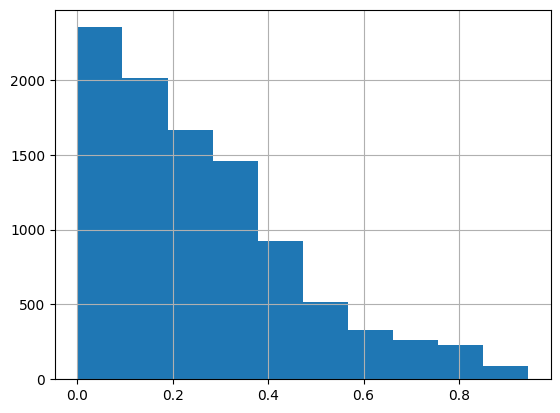

In [48]:
df_analysis.error_STD.hist()

In [114]:
df_errorMax = df_analysis[(df_analysis['error_STD'] >= 0.8)]
df_errorMax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 319 to 9827
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pair_ID           195 non-null    int64  
 1   normalized_score  195 non-null    float64
 2   Similarity_STD    195 non-null    float64
 3   Similarity_USE    195 non-null    float64
 4   A_obj             195 non-null    float32
 5   A_subj            195 non-null    float32
 6   B_obj             195 non-null    float32
 7   B_subj            195 non-null    float32
 8   A_SCA             195 non-null    object 
 9   B_SCA             195 non-null    object 
 10  error_STD         195 non-null    float64
 11  error_USE         195 non-null    float64
 12  delta_Obj         195 non-null    float32
 13  delta_Subj        195 non-null    float32
dtypes: float32(6), float64(5), int64(1), object(2)
memory usage: 18.3+ KB


In [115]:
df_errorMin = df_analysis[(df_analysis['error_STD'] <= 0.2)]
df_errorMin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4582 entries, 0 to 9746
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pair_ID           4582 non-null   int64  
 1   normalized_score  4582 non-null   float64
 2   Similarity_STD    4582 non-null   float64
 3   Similarity_USE    4582 non-null   float64
 4   A_obj             4582 non-null   float32
 5   A_subj            4582 non-null   float32
 6   B_obj             4582 non-null   float32
 7   B_subj            4582 non-null   float32
 8   A_SCA             4582 non-null   object 
 9   B_SCA             4582 non-null   object 
 10  error_STD         4582 non-null   float64
 11  error_USE         4582 non-null   float64
 12  delta_Obj         4582 non-null   float32
 13  delta_Subj        4582 non-null   float32
dtypes: float32(6), float64(5), int64(1), object(2)
memory usage: 429.6+ KB


In [116]:
df_errorMin.describe()

pair_ID  normalized_score  Similarity_STD  Similarity_USE        A_obj       A_subj        B_obj       B_subj     error_STD    error_USE    delta_Obj   delta_Subj
count  4582.000000       4582.000000     4582.000000     4582.000000  4582.000000  4582.000000  4582.000000  4582.000000  4.582000e+03  4582.000000  4582.000000  4582.000000
mean   4889.759057          0.816150        0.873449        0.795130     0.851516     0.397280     0.865896     0.399246  9.382749e-02     0.078629     0.047567     0.075110
std    2804.536142          0.130972        0.114543        0.164200     0.095837     0.140082     0.083706     0.133577  5.735089e-02     0.072980     0.064981     0.073237
min       1.000000          0.025000        0.186856        0.068679     0.296842     0.122618     0.320111     0.131682  1.355677e-08     0.000006     0.000005     0.000050
25%    2527.250000          0.725000        0.806679        0.692895     0.827362     0.289663     0.848456     0.297214  4.339440e-02     0.023997     0.008207     0.021935
50%    4794.000000          0.825000        0.898988        0.829211     0.885388     0.386080     0.893404     0.395123  9.241801e-02     0.058198     0.021956     0.051687
75%    7365.500000          0.925000        0.970088        0.933626     0.912634     0.495244     0.917537     0.488138  1.421410e-01     0.110057     0.056749     0.106417
max    9907.000000          1.000000        1.000000        0.998440     0.959302     0.801621     0.965110     0.801621  1.999999e-01     0.704873     0.509593     0.548139

In [117]:
# Preparando os dados para a regressão
X = df_errorMax[['delta_Subj', 'delta_Obj']]
y = df_errorMax['error_STD']

# Adicionando uma constante (intercepto) ao modelo
X = sm.add_constant(X)

# Ajustando o modelo de regressão linear
model = sm.OLS(y, X).fit()

# Imprimindo o sumário do modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              error_STD   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.1943
Date:                Tue, 13 Feb 2024   Prob (F-statistic):              0.824
Time:                        21:31:02   Log-Likelihood:                 367.07
No. Observations:                 195   AIC:                            -728.1
Df Residuals:                     192   BIC:                            -718.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8496      0.005    176.671      0.0

In [118]:
# Preparando os dados para a regressão
X = df_errorMin[['delta_Subj', 'delta_Obj']]
y = df_errorMin['error_STD']

# Adicionando uma constante (intercepto) ao modelo
X = sm.add_constant(X)

# Ajustando o modelo de regressão linear
model = sm.OLS(y, X).fit()

# Imprimindo o sumário do modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              error_STD   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     76.06
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           3.20e-33
Time:                        21:31:03   Log-Likelihood:                 6671.7
No. Observations:                4582   AIC:                        -1.334e+04
Df Residuals:                    4579   BIC:                        -1.332e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0824      0.001     65.079      0.0

In [119]:
from scipy import stats

In [120]:
# Teste t para A_subj
t_stat, p_val_A_subj = stats.ttest_ind(df_errorMin['A_subj'], df_errorMax['A_subj'])
print("Teste t para A_subj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_A_subj)

# Teste t para B_subj
t_stat, p_val_B_subj = stats.ttest_ind(df_errorMin['B_subj'], df_errorMax['B_subj'])
print("\nTeste t para B_subj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_B_subj)

# Teste t para delta_subj
t_stat, p_val_delta_subj = stats.ttest_ind(df_errorMin['delta_Subj'], df_errorMax['delta_Subj'])
print("\nTeste t para delta_subj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_delta_subj)

Teste t para A_subj:
t-Statistic: -0.2931141857269062
p-Value: 0.7694476112210179

Teste t para B_subj:
t-Statistic: 1.1705028257343497
p-Value: 0.24185709056453067

Teste t para delta_subj:
t-Statistic: -13.451458783470883
p-Value: 1.6368447060021778e-40


In [121]:
# Teste t para A_obj
t_stat, p_val_A_obj = stats.ttest_ind(df_errorMin['A_obj'], df_errorMax['A_obj'])
print("Teste t para A_obj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_A_obj)

# Teste t para B_obj
t_stat, p_val_B_obj = stats.ttest_ind(df_errorMin['B_obj'], df_errorMax['B_obj'])
print("\nTeste t para B_obj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_B_obj)

# Teste t para delta_subj
t_stat, p_val_delta_obj = stats.ttest_ind(df_errorMin['delta_Obj'], df_errorMax['delta_Obj'])
print("\nTeste t para delta_obj:")
print("t-Statistic:", t_stat)
print("p-Value:", p_val_delta_obj)

Teste t para A_obj:
t-Statistic: -6.817159959641764
p-Value: 1.0439881517709298e-11

Teste t para B_obj:
t-Statistic: -4.5237671204768315
p-Value: 6.222198054436157e-06

Teste t para delta_obj:
t-Statistic: -0.39228855852604366
p-Value: 0.694862524933509
